# Example `KBackground.Estimator` workflow with K2 Campaign 8

In this notebook we show how to use the `KBackground` tool to estimate rolling band. You can see a video of the rolling band in this dataset [here](https://www.youtube.com/watch?v=cAc70ErIsSQ).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from kbackground import Estimator
from astropy.io import fits
from astropy.table import Table

First we are going to get a number of the TPFs in a large superstamp in campaign 8. This will let us see a patch of data with a rolling band.

In [3]:
tpfs = []
for idx in np.arange(656, 656 + 26):
    tpfs.append(lk.search_targetpixelfile(f"EPIC 200068{idx}", mission='k2').download())

Next we will extract the row, column and flux values from all the TPFs.

In [21]:
rows, columns, fluxs, mission_bkgs, cadencenos = [], [], [], [], []
for tpf in tpfs:
    column, row = np.meshgrid(np.arange(tpf.column, tpf.shape[2] + tpf.column), np.arange(tpf.row, tpf.shape[1] + tpf.row))
    aper = np.ones(tpf.shape[1:], bool)
    rows.append(row[aper])
    columns.append(column[aper])
    fluxs.append(tpf.flux.value[:, aper] + tpf.flux_bkg.value[:, aper])
    cadencenos.append(tpf.cadenceno)

Next we can build the `Estimator` object, passing in the row, column, and flux values from all the TPFs.

In [146]:
e = Estimator(cadencenos[0], np.hstack(rows), np.hstack(columns), np.hstack(fluxs))

In [147]:
e.mask.sum()

9072

In [148]:
e.mask.sum()

9072

Under the hood, `KBackground` works on the median subtracted frames, below we plot a median subtracted frame which shows a rolling band.

Text(0, 0.5, 'Row')

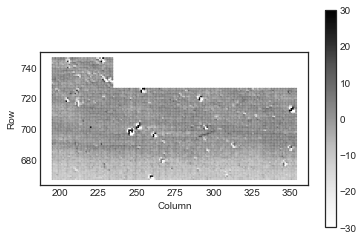

In [149]:
tdx = 870
med = e.flux[tdx] - np.median(e.flux, axis=0)
plt.scatter(np.hstack(columns), np.hstack(rows), s=1, c=med - np.median(med), vmin=-30, vmax=30)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel('Column')
plt.ylabel('Row')

We can access the model using

In [150]:
e.model

array([[328.89484265, 328.89484265, 328.89484265, ..., 330.1028594 ,
        330.1028594 , 330.1028594 ],
       [329.19066168, 329.19066168, 329.19066168, ..., 330.0636073 ,
        330.0636073 , 330.0636073 ],
       [329.40518184, 329.40518184, 329.40518184, ..., 330.0089385 ,
        330.0089385 , 330.0089385 ],
       ...,
       [818.79578996, 818.79578996, 818.79578996, ..., 818.05546281,
        818.05546281, 818.05546281],
       [819.0992562 , 819.0992562 , 819.0992562 , ..., 818.52933474,
        818.52933474, 818.52933474],
       [819.43972524, 819.43972524, 819.43972524, ..., 818.38780254,
        818.38780254, 818.38780254]])

This is an attribute we can index into to get a particular time-series

In [151]:
e.model[:, 1000]

array([329.25849029, 329.22527149, 329.21246265, ..., 818.71732974,
       819.10380717, 819.66182126])

We can plot the model for the same frame above.

[Text(0.5, 1.0, 'Model'), Text(0.5, 0, 'Column'), Text(0, 0.5, 'Row')]

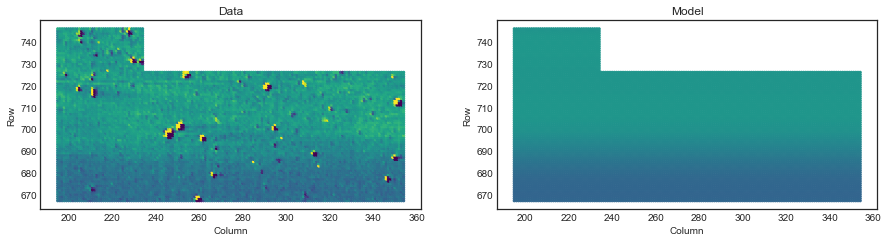

In [152]:
tdx = 890
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
med = e.flux[tdx] - np.median(e.flux, axis=0)

ax[0].scatter(np.hstack(columns), np.hstack(rows), s=5, c=(med - np.median(med))[None, :], vmin=-30, vmax=30, cmap='viridis')
ax[0].set_aspect('equal')
ax[0].set(title='Data', xlabel='Column', ylabel='Row')
ax[1].scatter(np.hstack(columns), np.hstack(rows), s=5, c=e.model[tdx] - np.median(e.model[tdx]), vmin=-30, vmax=30, cmap='viridis')
ax[1].set_aspect('equal')
ax[1].set(title='Model', xlabel='Column', ylabel='Row')

In [153]:
e.model[tdx] - med

array([394.66670639, 397.21440536, 396.18434555, ..., 394.32548671,
       397.14775233, 398.00032191])

Text(0, 0.5, 'Flux [counts]')

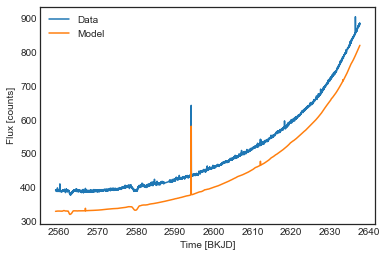

In [154]:
plt.plot(tpf.time.value, e.flux[:, 5060], label='Data')
plt.plot(tpf.time.value, e.model[:, 5060], label='Model')
plt.legend()
plt.xlabel('Time [BKJD]')
plt.ylabel('Flux [counts]')

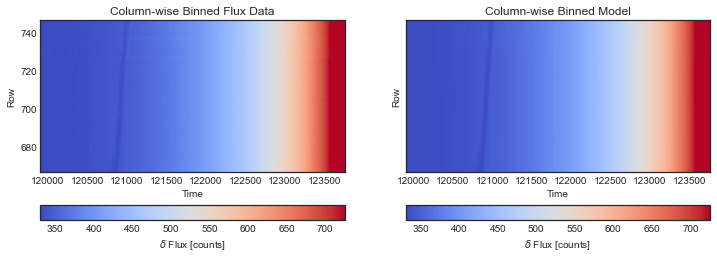

In [155]:
e.plot();

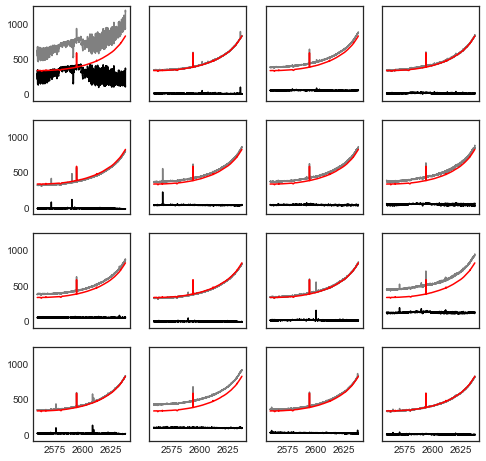

In [156]:
dim_pix = np.where(np.std(e.flux, axis=0) < np.nanpercentile(np.std(e.flux, axis=0), 20))[0]
fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
kdx = -1
for idx, jdx in enumerate(np.random.choice(dim_pix, 16)):
    if idx % 4 == 0:
        kdx += 1
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx], label='Data', c='grey')
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx] - e.model[:, jdx], label='Data', c='k')
    ax[kdx, idx % 4].plot(tpf.time.value, e.model[:, jdx], label='Model', c='r')
    ax[kdx, idx % 4].set(ylim=(-100, ax[kdx, idx % 4].get_ylim()[1]))